# Riiid---Answer-Correctness-Prediction
Predicting Student Performance on future interactions with an AI tutor
# Project Overview

## Issues in Education
First, I’d like to talk about some issues in education today. According to data gathered by the UNESCO Institute, in 2018, 260 million children weren’t attending school. Of the children that we’re attending school, more than half of young students around the globe did not meet minimum reading and math standards. This is in part due to the fact that many students don’t have access to personalized learning.

Education was already in a tough place before COVID forced many schools to shutdown and switch to remote learning. I created this map in Tableau with data from UNESCO Institute.

<b>School Closure Due to COVID-19 May 2020</b>
![COVID MAP](../../reports/figures/COVID_map_no_labels.png)

## Education with Artificial Intelligence
 Artificial Intelligent solutions can change the current education system in terms of attendance, engagement, and individualized attention. It could potentially provide equal opportunity in education to anyone with an internet connection. With these goals in mind, RIIID Labs developed AI tutors.

Aiming to rethink traditional ways of learning, RIID Labs launched EdNet this year, the world’s largest open database for AI education. The database, which is hosted on Kaggle.com, contains data on more than 100 million student interactions across almost 400 thousand students for over 13,000 questions.

## Student Performance Predictions on AI tutor
I will be predicting whether the student will answer incorrect, or correct for future questions. The purpose of these predictions is to help evaluate and guide the success of the AI tutors. The AI tutor can become more individualized to a student’s needs if they know the predicted performance. For example, it could provide more questions and lectures on topics it sees the student is predicted to be weak in.

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import riiid_functions

from dask.distributed import Client, LocalCluster
import joblib

In [2]:
cluster = LocalCluster()
client = Client(cluster) # start a local Dask client

In [3]:
cluster

# Data

#### Import Data

In the [Create SQL Database notebook](https://github.com/SinShady/Riiid_AI_Tutor-Answer_Correctness_Predictions/blob/main/notebooks/create_SQL_database.ipynb), we downloaded and imported the data into a newly created PostgreSQL database. In order to get the data on your local computer, follow the instructions in that notebook and you should be able to connect to the database and run the following cells.

In [4]:
# Connect to the PostgreSQL database riiid_education we created in our create SQL Database notebook
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

In [5]:
#create a list of the table names
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['train', 'questions', 'lectures', 'example_test']

In [6]:
# Read in Data from Database as pandas dataframes
train = pd.read_sql("""SELECT * 
FROM train;""", conn)
questions = pd.read_sql("SELECT * FROM questions;", conn)
lectures = pd.read_sql("SELECT * FROM lectures;", conn)
conn.close()

### Data Understanding

<b>Description of Features in Train</b>

`row_id` - ID for the row.

`timestamp` - the time between this user interaction and the first event from that user.

`user_id` - ID for the user.

`content_id` - ID for the user interaction

`content_type_id` - 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture. Every row with 1 has an answered_correctly value of not answered(-1). Filtering out all rows with content id 1 filters out all the unanswered questions. This is the culprit of our 100% predictions on unanswered.

`task_container_id` - ID for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

`user_answer` - the user's answer to the question, if any. Read -1 as null, for lectures.

`answered_correctly` - if the user responded correctly. Read -1 as null, for lectures.

`prior_question_elapsed_time` - How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

`prior_question_had_explanation` - Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [8]:
train.shape
# 101,230,332 rows

(101230332, 10)

In [9]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in train.columns:
    print(f"{column}: {train[column].nunique()}")

Count of unique values in each column
row_id: 101230332
timestamp: 72821015
user_id: 393656
content_id: 13782
content_type_id: 2
task_container_id: 10000
user_answer: 5
answered_correctly: 3
prior_question_elapsed_time: 3258
prior_question_had_explanation: 2


Categorical Features: `content_type_id`, `user_answer`, `answered_correctly`, `prior_question_had_explanation`

<b>Description of Features in Questions</b>

`question` - foreign key for the train/test content_id column, when the content type is question (0).

`bundle_id` - code for which questions are served together.

`correct_answer` - the answer to the question. Can be compared with the train user_answer column to check if the user was right.

`part` - top level category code for the question.

`tags` - one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [10]:
questions.head()

,question,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38 ...
1,1,1,1,1,131 36 81 ...
2,2,2,0,1,131 101 162 92 ...
3,3,3,0,1,131 149 162 29 ...
4,4,4,3,1,131 5 162 38 ...


In [11]:
questions.shape

(13523, 5)

In [12]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in questions.columns:
    print(f"{column}: {questions[column].nunique()}")

Count of unique values in each column
question: 13523
bundle_id: 9765
correct_answer: 4
part: 7
tags: 1519


Categorical Features: `correct_answer`, `part`

Note - Should only need bundle_id, correct_answer and part column.

<b>Description of Features in Lectures</b>

Note - Wont be using this table for our model

`lecture_id` - foreign key for the train/test content_id column, when the content type is lecture (1).

`part` - top level category code for the lecture.

`tag` - one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

`type_of` - brief description of the core purpose of the lecture

In [13]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [14]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in lectures.columns:
    print(f"{column}: {lectures[column].nunique()}")

Count of unique values in each column
lecture_id: 418
tag: 151
part: 7
type_of: 4


### Data Engineering

Later in the notebook, we create a function to do the following data engineering, but I've left this in here for a look at the process.

A I am only predicting student answers on questions, there was no need for the lectures data. I joined the train and questions tables on the `content_id` and `question` columns and dropped the columns `user_answer` (since real training data could not have this column), `tags`, and `content_id`.

Since the original features were not enough for my model to make accurate predictions, I engineered the following features.
- `user_question_count` - the cumulative count of questions each user has answered
- `avg_time_per_question` - the cumulative average time spent per question per user
- `question_difficulty` - the ratio of wrong answers to total answers per question

In [15]:
# Drop all rows with answered_correctly is blank (-1) since these are lectures, not questions
train = train[train.content_type_id != 1]

# prior_question_had_explanation is type string and should be type bool
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')

#### Merge train and questions tables

In [16]:
df = train.merge(questions, left_on='content_id', right_on='question', how='left')

In [17]:
# Drop the columns we don't need
# question is already there as content id
# user_answer doesn't make sense to have - we can't know that in advance
# There are only 2 unique content_type_ids and we dropped one type, no point having a column of zeros
# tags has to do with the lecture tags, adressing would be way too calculation heavy for my computer to handle.
df.drop(['tags', 'question', 'user_answer', 'content_type_id'], axis=1, inplace=True)

#### Feature Engineering

In [18]:
# Engineer Feature for how many questions this user has answered prior
df["user_question_count"] = df.groupby("user_id").cumcount() + 1

In [19]:
# Engineer Feature for average time per questions per user for prior questions
cumsum = df.groupby("user_id")["prior_question_elapsed_time"].cumsum()
count = df.groupby("user_id").cumcount() + 1
df["avg_time_per_question"] = round(cumsum/count, 0)

In [20]:
# Engineer Feature for question difficulty (ratio of incorrect/all answers)
correct_answers = df.groupby("content_id")["answered_correctly"].sum()
all_answers = df.groupby("content_id")["answered_correctly"].count()
wrong_answers = all_answers-correct_answers
question_difficulty = pd.DataFrame(wrong_answers/all_answers)

# Decided not to bin
# # Bin difficulty on a scale of 1->10, 1 being easy, 10 being difficult
# question_difficulty_binned = pd.cut(x=question_difficulty['answered_correctly'],
#                                     bins=np.linspace(0,1,11),
#                                     labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# question_difficulty_binned = pd.DataFrame(question_difficulty_binned)

question_difficulty = question_difficulty.rename(columns={"answered_correctly": "question_difficulty"}).reset_index()

In [21]:
# Merge question_difficulty_binned into main DataFrame
df= df.merge(question_difficulty, on='content_id', how="left")

In [22]:
# Split data into features and target
X = df.drop('answered_correctly', axis=1)
y = df['answered_correctly'] 

### Data Visualization

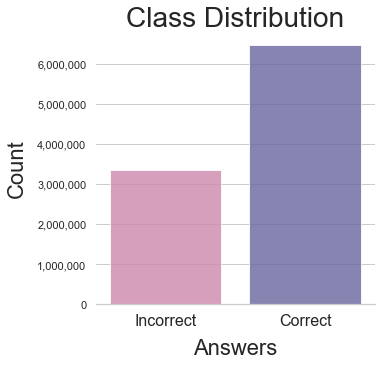

In [111]:
# Class Distribution
sns.set(context = 'notebook', style='whitegrid')
fig, ax = plt.subplots(figsize = (5,5)) 
ax = sns.countplot(y, palette = ['#d77ead', '#645ca7'], alpha=.8)
ax.axes.set_title("Class Distribution",fontsize=28)
ax.set_xlabel("Answers",fontsize=22, labelpad=10)
ax.set_ylabel("Count",fontsize=22, labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=16)
# ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/class_imbalance.png', bbox_inches='tight', transparent=True);

This is the distribution of our target variable - answers - in the Ednet Database. We can see students are getting over twice as many answers correct than incorrect.

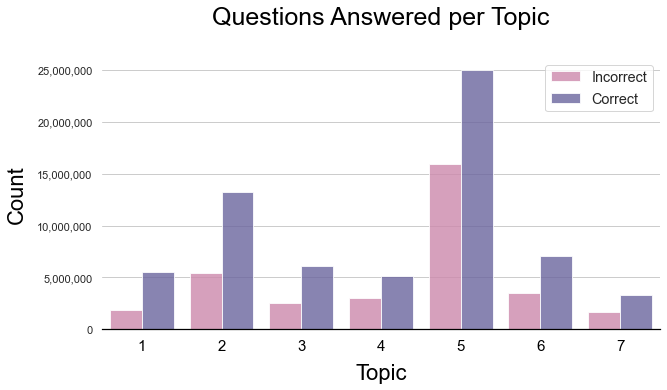

In [24]:
# Viz for Questions Answered per Topic
sns.set(context = 'notebook', style='whitegrid')
plt.figure(figsize = (10, 5))
ax = sns.countplot(data=df, x='part', hue='answered_correctly', palette=['#d77ead', '#645ca7'], alpha=.8)
ax.set(xlabel = '', ylabel = '')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
ax.axes.set_title("Questions Answered per Topic", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Topic",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='black', labelpad=10)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='black')
# ax.set_yticklabels(['0', '5,000,000', '10,000,000', '15,000,000', '20,000,000', '25,000,000'], fontsize=15, color='black')
# ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/parts.png', bbox_inches='tight', transparent=True);

Another feature in the dataset was topics numbered from 1-7 shown by this plot. Ednet has not provided the information for which number belongs to which topic, but that’s understandable given consideration of student privacy. Here we can see some topics have a greater class imbalance than others, which means this feature will help our model more accurately predict student outcomes. For example, students on average seem to be performing better on topic 1 than on topic 4. Topic 5 seems to be very popular.

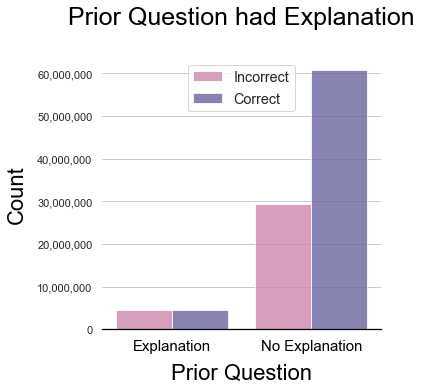

In [25]:
plt.figure(figsize = (5, 5))
ax = sns.countplot(data=df, x='prior_question_had_explanation', hue='answered_correctly', palette=['#d77ead', '#645ca7'], alpha=.8)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20', loc='upper center')
ax.axes.set_title("Prior Question had Explanation", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Prior Question",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='black', labelpad=10)
ax.set_xticklabels(['Explanation', 'No Explanation'], fontsize=15, color='black')
# ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/prior_q_explanation.png', bbox_inches='tight', transparent=True);

Another feature was if the prior qestion had an explanation or not. As it looks like most prior questions did not have an explantion, this feature doesnt seem immensly helpful for my model.

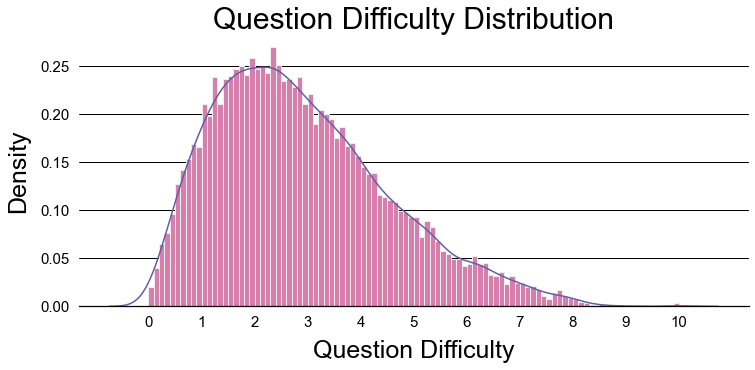

In [32]:
# Viz for dist plot for question difficulty
plt.figure(figsize = (12, 5))
ax = sns.distplot(question_difficulty['question_difficulty']*10, bins=100, kde_kws=dict(color = '#645ca7', linewidth=1.5),
                  color='#d77ead', hist_kws=dict(alpha=1))
ax.set_title("Question Difficulty Distribution", fontsize=30, color='black')
ax.set_xlabel("Question Difficulty",fontsize=25, color='black', labelpad=10)
ax.set_ylabel("Density",fontsize=25, color='black', labelpad=10)
plt.xticks(range(0,11), fontsize=15, color='black')
plt.yticks(fontsize=15, color='black')
ax.grid(False)
ax.grid(color='black', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
plt.setp(ax.patches, linewidth=1, edgecolor='#eeeeee')
plt.savefig('../../reports/figures/Question_difficulty.png', bbox_inches='tight', transparent=True);

To improve my model performance, I also engineered features such as the cumulative question count per user, cumulative average time per question per user, and question difficulty which we can see represented here on a scale of 0 to 10 as a right skewed normal distribution. This new feature significantly increased my model performance. I calculated this by dividing the number of incorrect answers by the amount of total answers per unique question in the database. For all the questions with a difficulty of 0, every student answered correctly, while for all the questions with a difficulty of 10, nobody answered correctly. The average question, has a difficulty around 2, meaning about 80% of students answered those questions correctly

Taking a subset of the data to work with to create violin plots without too much noise

In [33]:
# Take a subset of the data to work with (1,000,000 rows)
# Taking the first 1,000,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data_small = pd.read_sql("""SELECT * 
FROM train
LIMIT 1000000;""", conn)

conn.close()

The code for the following function resides in riiid_functions.py in the src folder

In [35]:
df_small = riiid_functions.engineer_data(data_small, question_difficulty)

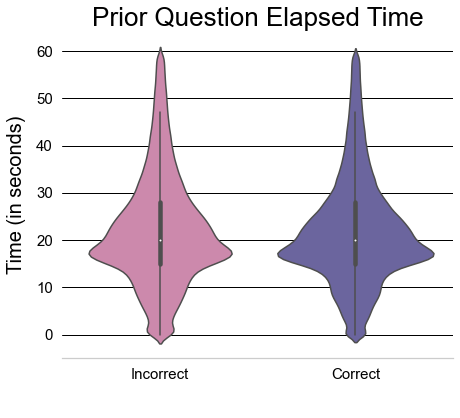

In [36]:
# Violin Plot for Prior_Question_Elapsed_Time
df_small['prior_question_time_seconds'] = df_small['prior_question_elapsed_time'].fillna(0).apply(riiid_functions.time_reformat_seconds)
# df['prior_question_time_datetime'] = df['prior_question_time_datetime'].apply(time_reformat)
# prior_question
plt.figure(figsize = (7, 6))
ax = sns.violinplot(y='prior_question_time_seconds', x='answered_correctly', data=df_small, palette=['#d77ead', '#645ca7'])
ax.set_title("Prior Question Elapsed Time", fontsize=26, color='black')
ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='black')
ax.set_xlabel("Answers",fontsize=20, color='white', labelpad=10)
ax.set_ylabel("Time (in seconds)",fontsize=20, color='black', labelpad=10)
plt.xticks(fontsize=15, color='black');
plt.yticks(fontsize=15, color='black')
ax.grid(False)
ax.grid(color='black', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('../../reports/figures/prior_question_time_violin.png', bbox_inches='tight', transparent=True);

Features in the dataset also include cumulative timestamps per user, and prior question elapsed time, which is shown here as a violin plot. The widest part shows how long most questions took to answer, which is around 18 seconds. The next wide part is at 0 since the prior question elapsed time for the first question for every user is 0. We can see that most users tend to get the first question wrong. The small white dot shows the average time per question – 20 seconds. Overall, the shapes of both violins are very similar which suggests that this feature will only help a little in predicting student answers.

### Prepare data for modeling

 As the dataset of over 100,000 student interactions was too big for my sole computer to handle, I used a subset - 1 million interactions to choose and tune my models

In [96]:
# Taking an even smaller subset of the data to run our various models (100,000 rows)
# Taking the first 100,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()
data_smallest = pd.read_sql("""SELECT * 
FROM train
LIMIT 100000;""", conn)
conn.close()

df_smallest = riiid_functions.engineer_data(data_smallest, question_difficulty)

In [97]:
# Split data into features and target
X = df_smallest.drop('answered_correctly', axis=1)
y = df_smallest['answered_correctly'] 

# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [98]:
# Pipeline for preprocessing numeric features
# numeric_features = list(X.select_dtypes(exclude='object').columns)
numeric_features = ['timestamp', 'row_id', 'user_id', 'content_id', 'task_container_id', 'question_difficulty',
                    'prior_question_elapsed_time', 'avg_time_per_question', 'bundle_id', 'user_question_count']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline for preprocessing categorical features
# categorical_features = list(X.select_dtypes(include='object').columns)
categorical_features = ['part', 'prior_question_had_explanation', 'correct_answer']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value='None')),
    ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Pipeline for preprocessing combined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [99]:
# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Modeling

#### First Simple Model

In [41]:
# Logistic Regression Model Fit
fsm = LogisticRegression()
fsm.fit(X_train_transformed, y_train)

LogisticRegression()

In [42]:
# Score on our training data
y_pred = fsm.predict(X_train_transformed)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.36      0.46     26911
           1       0.73      0.88      0.80     51358

    accuracy                           0.70     78269
   macro avg       0.67      0.62      0.63     78269
weighted avg       0.69      0.70      0.68     78269



In [43]:
# Score on our testing data
y_pred = fsm.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.37      0.46      6670
           1       0.73      0.88      0.80     12898

    accuracy                           0.70     19568
   macro avg       0.67      0.62      0.63     19568
weighted avg       0.69      0.70      0.68     19568



In [44]:
cross_val_score(fsm, X_train_transformed, y_train, cv=4)

array([0.70569297, 0.70608678, 0.70373588, 0.6999029 ])

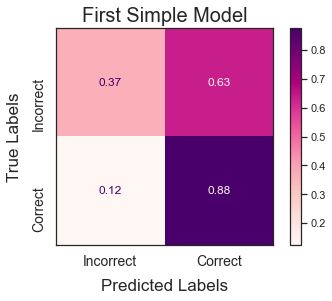

In [45]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(fsm, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.title('First Simple Model',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14)
plt.savefig('../../reports/figures/fsm_matrix.png', bbox_inches='tight', transparent=True);

We are severely underpredicting incorrectly answered. Our recall is a mere .12. This is due to class imbalance - there are much more correctly answered questions than incorrect. Let's resample the data the adress this issue

### Further Data Preprocessing

#### Using Smote to Deal with Class Imbalance

In [46]:
print("Before OverSampling, counts of label -1: {}".format(sum(y_train == -1))) 
print("Before OverSampling, counts of label 0: {}".format(sum(y_train == 0))) 
print("Before OverSampling, counts of label 1: {} \n".format(sum(y_train == 1))) 

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label -1: {}".format(sum(y_train_res == -1))) 
print("Before OverSampling, counts of label 0: {}".format(sum(y_train == 0))) 
print("After OverSampling, counts of label 1: {}".format(sum(y_train_res == 1)))

Before OverSampling, counts of label -1: 0
Before OverSampling, counts of label 0: 26911
Before OverSampling, counts of label 1: 51358 

After OverSampling, the shape of train_X: (102716, 23)
After OverSampling, the shape of train_y: (102716,) 

After OverSampling, counts of label -1: 0
Before OverSampling, counts of label 0: 26911
After OverSampling, counts of label 1: 51358


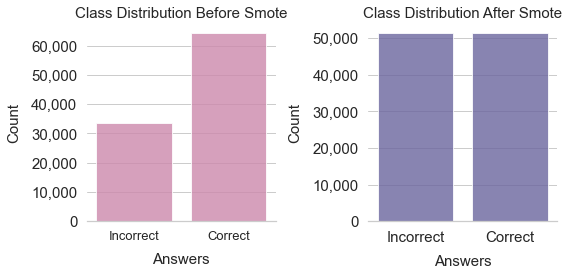

In [47]:
sns.set(context = 'notebook', style = 'whitegrid')

fig, axes = plt.subplots(1, 2, figsize = (8,4)) 
ax = sns.countplot(y, palette = ['#d77ead', '#d77ead'], ax=axes[0], alpha=.8)
ax.set_title("Class Distribution Before Smote",fontsize=15)
ax.set_xlabel("Answers",fontsize=15, labelpad=10)
ax.set_ylabel("Count",fontsize=15,  labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=13)
ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax2 = sns.countplot(y_train_res, palette = ['#645ca7', '#645ca7'], ax=axes[1], alpha=.8)
ax2.set_title("Class Distribution After Smote",fontsize=15)
ax2.set_xlabel("Answers",fontsize=15, labelpad=10)
ax2.set_ylabel("Count",fontsize=15,  labelpad=10)
ax2.set_xticklabels(['Incorrect', "Correct"], fontsize=15)
ax2.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

fig.tight_layout()
plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');

#### Logistic Regression After Smote

In [48]:
# # Grid Search for best params for Logistic Regression Classifier
# params = {
#     'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
#     'solver':['liblinear', 'saga'],
#     'C': [.001,.1, 1, 10],
#     'verbose': [0, 1],
#     'max_iter': [.5, 1, 2],
#     'tol': [1, 10, 100]
# }
# lr_gs = GridSearchCV(LogisticRegression(random_state=42), params, cv=3)
# with joblib.parallel_backend('dask'):
#     lr_gs.fit(X_train_res, y_train_res)

# print("Best Params", lr_gs.best_params_)
# print("Best Score", lr_gs.best_score_)

# # Best Params {'C': 1, 'max_iter': 5, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1, 'verbose': 0}
# # Best Score 0.5575444544102709

In [49]:
# Plug in best params and run model
lr_best = LogisticRegression(random_state=42, penalty= 'l2', solver= 'liblinear', C=1, verbose=0, max_iter=1, tol=1)
lr_best.fit(X_train_res, y_train_res)

LogisticRegression(C=1, max_iter=1, random_state=42, solver='liblinear', tol=1)

In [50]:
# Score on our training data
y_pred = lr_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64     51358
           1       0.65      0.70      0.67     51358

    accuracy                           0.66    102716
   macro avg       0.66      0.66      0.66    102716
weighted avg       0.66      0.66      0.66    102716



In [51]:
# Score on testing data
y_pred = lr_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.62      0.56      6670
           1       0.78      0.70      0.74     12898

    accuracy                           0.67     19568
   macro avg       0.65      0.66      0.65     19568
weighted avg       0.69      0.67      0.68     19568



In [52]:
cross_val_score(lr_best, X_train_transformed, y_train, cv=4)

array([0.70528414, 0.70368478, 0.70046507, 0.6983697 ])

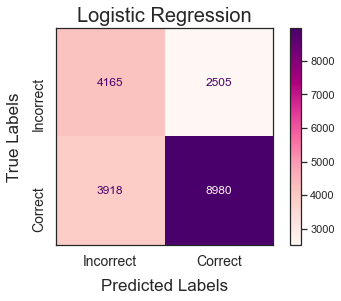

In [53]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(lr_best, X_test_transformed, y_test, cmap='RdPu')
plt.title('Logistic Regression',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### K Nearest Neighbors

In [54]:
# # Grid Search for best params for KNN Classifier *Do this overnight, takes forever*
# params = {
#     'n_neighbors': [3, 5],
#     'weights': ['uniform', 'distance'],
#     'p' : [1,2]
# }

# knn_gs = GridSearchCV(KNeighborsClassifier(), params)
# with joblib.parallel_backend('dask'):
#     knn_gs.fit(X_train_res, y_train_res)

# print("Best Params", knn_gs.best_params_)

In [55]:
# Plug in best params and run model
knn_best = KNeighborsClassifier()
knn_best.fit(X_train_res, y_train_res)

KNeighborsClassifier()

In [56]:
# Score on our training data
y_pred = knn_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     51358
           1       0.87      0.74      0.80     51358

    accuracy                           0.81    102716
   macro avg       0.82      0.81      0.81    102716
weighted avg       0.82      0.81      0.81    102716



In [57]:
# Score on testing data
y_pred = knn_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.60      0.52      6670
           1       0.76      0.63      0.69     12898

    accuracy                           0.62     19568
   macro avg       0.61      0.62      0.60     19568
weighted avg       0.65      0.62      0.63     19568



In [58]:
cross_val_score(knn_best, X_train_transformed, y_train, cv=4)

array([0.67324203, 0.67593397, 0.67036337, 0.67480963])

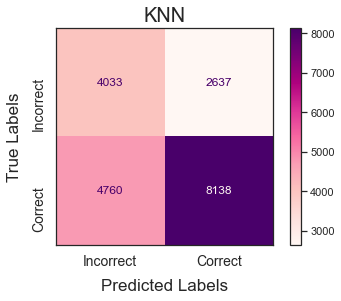

In [59]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(knn_best, X_test_transformed, y_test, cmap='RdPu')
plt.title('KNN',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Random Forest

In [60]:
# # Grid Search for best params for Random Forest Classifier
# params = {
#     'max_depth': [10, 16, 20],
#     'n_estimators': [700, 800]
# }

# rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), params)
# with joblib.parallel_backend('dask'):
#     rf_gs.fit(X_train_res, y_train_res)

# print("Best Params", rf_gs.best_params_)

In [61]:
# Plug in best params and run model
rf_best = RandomForestClassifier(max_depth=16, n_estimators=700, random_state=42)
with joblib.parallel_backend('dask'):
    rf_best.fit(X_train_res, y_train_res)

In [62]:
# Score on our training data
y_pred = rf_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     51358
           1       0.88      0.85      0.86     51358

    accuracy                           0.87    102716
   macro avg       0.87      0.87      0.87    102716
weighted avg       0.87      0.87      0.87    102716



In [63]:
# Score on testing data
y_pred = rf_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.64      0.58      6670
           1       0.79      0.71      0.75     12898

    accuracy                           0.69     19568
   macro avg       0.66      0.68      0.66     19568
weighted avg       0.70      0.69      0.69     19568



In [64]:
cross_val_score(rf_best, X_train_transformed, y_train, cv=4)

array([0.71754906, 0.71819901, 0.71446824, 0.71625696])

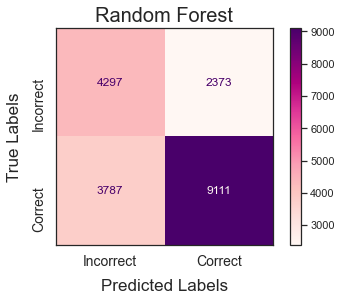

In [65]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(rf_best, X_test_transformed, y_test, cmap='RdPu', values_format = '.0f')
plt.title('Random Forest',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### AdaBoost

In [66]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_res, y_train_res)

AdaBoostClassifier(random_state=42)

In [67]:
# Score on our training data
y_pred = adaboost.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69     51358
           1       0.69      0.64      0.67     51358

    accuracy                           0.68    102716
   macro avg       0.68      0.68      0.68    102716
weighted avg       0.68      0.68      0.68    102716



In [68]:
# Score on testing data
y_pred = adaboost.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59      6670
           1       0.81      0.63      0.71     12898

    accuracy                           0.66     19568
   macro avg       0.66      0.67      0.65     19568
weighted avg       0.70      0.66      0.67     19568



In [69]:
cross_val_score(adaboost, X_train_transformed, y_train, cv=4)

array([0.70763491, 0.71487709, 0.71155517, 0.70537129])

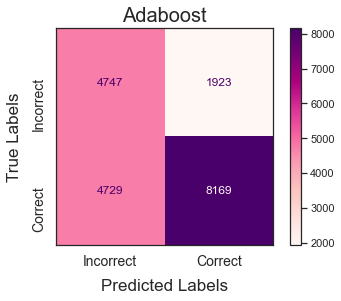

In [70]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(adaboost, X_test_transformed, y_test, cmap='RdPu')
plt.title('Adaboost',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Extreme Gradient Boosting

In [71]:
# Instantiate XGBClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
# XGB Optomized for distributed computing. Parallel training.
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(random_state=42)

In [72]:
# Score on our training data
y_pred = xgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.72      0.71     51358
           1       0.71      0.68      0.69     51358

    accuracy                           0.70    102716
   macro avg       0.70      0.70      0.70    102716
weighted avg       0.70      0.70      0.70    102716



In [73]:
# Score on testing data
y_pred = xgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.69      0.59      6670
           1       0.81      0.67      0.73     12898

    accuracy                           0.68     19568
   macro avg       0.66      0.68      0.66     19568
weighted avg       0.71      0.68      0.68     19568



In [74]:
cross_val_score(xgb, X_train_transformed, y_train, cv=4)

array([0.71642478, 0.72090765, 0.71564369, 0.71518373])

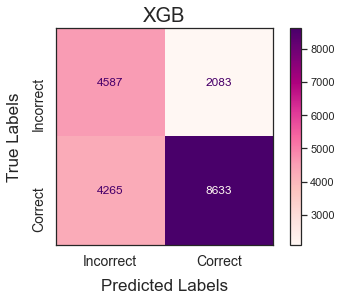

In [75]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(xgb, X_test_transformed, y_test, cmap='RdPu')
plt.title('XGB',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);
plt.savefig('../../reports/figures/xgb_matrix.png', bbox_inches='tight', transparent=True);

#### Light Gradient Boosting

In [101]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
lgb = LGBMClassifier(seed=42)
lgb.fit(X_train_res, y_train_res)

LGBMClassifier(seed=42)

In [102]:
# Score on our training data
y_pred = lgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72    515117
           1       0.72      0.76      0.74    515117

    accuracy                           0.73   1030234
   macro avg       0.73      0.73      0.73   1030234
weighted avg       0.73      0.73      0.73   1030234



In [103]:
# Score on testing data
y_pred = lgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.88      0.56      6782
           1       0.84      0.32      0.47     12783

    accuracy                           0.52     19565
   macro avg       0.62      0.60      0.51     19565
weighted avg       0.69      0.52      0.50     19565



In [104]:
cross_val_score(lgb, X_train_transformed, y_train, cv=4)

array([0.71305903, 0.71300792, 0.70999233, 0.71145982])

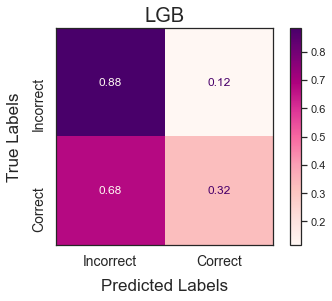

In [105]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(lgb, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.title('LGB',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Training our best model(Light Gradient Boost) with a bigger subset of the Data

In [112]:
# Take a larger subset of the data to run the final model on (10,000,000 rows)
# Taking the first 1,000,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data = pd.read_sql("""SELECT * 
FROM train
LIMIT 1000000;""", conn)

conn.close()

df = riiid_functions.engineer_data(data, question_difficulty)

# Split data into features and target
X = df.drop('answered_correctly', axis=1)
y = df['answered_correctly'] 

# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel())

In [ ]:
# Plug in best params and run model
best_model = RandomForestClassifier(max_depth=16, n_estimators=700, random_state=42)
with joblib.parallel_backend('dask'):
    best_model.fit(X_train_res, y_train_res)

In [ ]:
# Score on testing data
y_pred = best_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

In [ ]:
# Cross Validation Scores
cross_val_score(best_model, X_train_transformed, y_train, cv=4)

In [ ]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(best_model, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.title('Random Forest',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14)
plt.savefig('../../reports/figures/random_forest_matrix.png', bbox_inches='tight', transparent=True);

#### To use our model on a new dataset, import the test set as a pandas dataframe called data and run the following

In [ ]:
# # Use our function which does our data engineering
# df = engineer_data(data)

# # Use preprocessing pipeline which is fit on our train data to transform the test data
# X_test = preprocessor.transform(df)

# # Make Predictions
# y_pred = best_model.predict(X_test)

# Conclusion
In conclusion, we can use these predictions to improve and prove the success of AI tutors. Knowing how the student is likely to perform in the future can give better insight for the AI to individualize education and personalize the learning experience for each student to achieve the best results. I strongly believe that if features about student demographics were included in the database, the model accuracy would greatly improve and student success in underprivileged areas could be addressed and improved by the AI tutor as well.

AI tutors could be a much needed change in our education system to provide equal opportunity and improve the success of students around the globe.

# Next Steps
- As engineering new features is what improved my model the most in the end, in the futures, I would like to brainstorm more creative ideas for features to add.
- With the limitations of my computer, I was only able to use 1% of the dataset for my current model, even after using the dask package for parallel computing. Being able to fit the entire dataset of 100 million student interactions could improve my model.
- I want to try a neural network model and see how it does with this database.
- I would also like to create a deployable web app for my model using flask.